# Multi-channel slow-wave detection

This notebook demonstrates how to use YASA to perform **multi-channel slow-waves detection** from a NumPy array (example 1) or a MNE Raw object (example 2). If you haven't done so already, check out the notebook on [single-channel slow-waves detection](05_sw_detection.ipynb).

Please make sure to install the latest version of YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

**Important**
- The data must be a numpy array of shape *(n_channels, n_samples)*.
- The sampling frequency `sf` must be the same for all channels.
- A list of the channel names (`ch_names`) must be provided as well.
- The unit of the data must be $\mu V$. Note that the default unit in [MNE](https://martinos.org/mne/dev/generated/mne.io.Raw.html) is $V$. Therefore, if you use MNE, you must multiply your data by 1e6 (1 $V$ = 1,000,000 $\mu V$).

## Example 1: Using NumPy

To illustrate the multi-channel slow-waves detection, we load a full-night 3-channels dataset (Cz, Fz, Pz) sampled at 100 Hz. The data is in compressed NumPy format (*.npz*).

In [1]:
import mne
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, chan = f['data'], f['chan']
hypno = np.load('data_full_6hrs_100Hz_hypno.npz').get('hypno')
sf = 100.
times = np.arange(data.size) / sf

print(data.shape, chan)

(3, 2161058) ['Cz' 'Fz' 'Pz']


To apply the multi-channel detection, we use the [sw_detect](https://raphaelvallat.com/yasa/build/html/generated/yasa.spindles_detect.html#yasa.spindles_detect) function. Note that we pass the hypnogram and restrain the detection to N2 or N3 sleep.

In [2]:
sw = yasa.sw_detect(data, sf, ch_names=chan, hypno=hypno, include=(2, 3))

# Get the full detection dataframe
sw.summary().round(2)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel
0,529.48,529.78,530.02,530.23,530.48,1.00,-43.37,34.23,77.60,323.32,1.00,2,Cz,0
1,644.28,644.54,644.76,644.96,645.15,0.87,-59.70,47.28,106.98,486.29,1.15,2,Cz,0
2,645.15,645.37,645.59,645.82,646.03,0.88,-48.10,48.93,97.03,441.03,1.14,2,Cz,0
3,646.03,646.26,646.45,646.68,646.88,0.85,-53.67,70.08,123.74,651.28,1.18,2,Cz,0
4,646.88,647.08,647.29,647.48,647.71,0.83,-66.64,52.30,118.95,566.41,1.20,2,Cz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6992,20499.71,20500.10,20500.38,20500.69,20501.05,1.34,-78.05,80.09,158.14,564.79,0.75,2,Pz,2
6993,20501.05,20501.29,20501.51,20501.76,20502.05,1.00,-41.65,45.12,86.77,394.42,1.00,2,Pz,2
6994,20523.82,20524.15,20524.36,20524.62,20524.99,1.17,-64.73,92.05,156.78,746.59,0.85,2,Pz,2
6995,20525.61,20526.21,20526.49,20526.76,20527.36,1.75,-80.46,52.00,132.47,473.10,0.57,2,Pz,2


In [3]:
# Get the average per channel and stage
sw.summary(grp_chan=True, grp_stage=True, aggfunc='mean')

Count    Density  Duration  ValNegPeak  ValPosPeak         PTP  \
Stage Channel                                                                   
2     Cz         477   3.019226  1.203354  -78.654530   57.765269  136.419800   
      Fz         416   2.633120  1.181635  -88.028501   56.238414  144.266915   
      Pz         416   2.633120  1.273101  -73.346148   57.200875  130.547023   
3     Cz        1936  21.628264  1.156271  -76.036749   63.328056  139.364805   
      Fz        1884  21.047340  1.147707  -72.681406   60.168087  132.849492   
      Pz        1868  20.868594  1.173185  -78.509145   63.952058  142.461203   

                    Slope  Frequency  
Stage Channel                         
2     Cz       515.759692   0.883919  
      Fz       545.816723   0.900314  
      Pz       476.516677   0.836252  
3     Cz       539.105399   0.921905  
      Fz       524.391816   0.924978  
      Pz       538.441727   0.908249

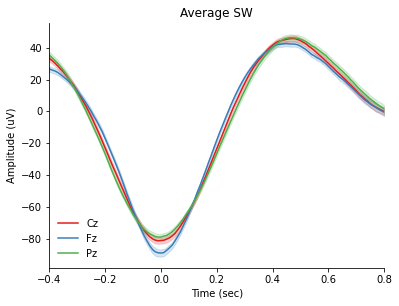

In [4]:
# Plot an average template of the detected slow-waves, centered around the negative peak
ax = sw.plot_average(center="NegPeak", time_before=0.4, 
                     time_after=0.8, palette="Set1")
ax.legend(frameon=False)
sns.despine()

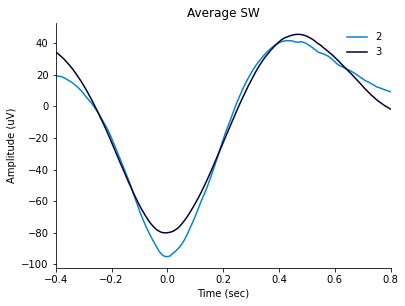

In [5]:
# Same but grouped by stage, using the `hue="Stage"` input parameter (default is "Channel")
# Note that we're also disabling the time-consuming bootstrapped confidence 
# intervals with `ci=None`.
ax = sw.plot_average(center="NegPeak", hue="Stage", time_before=0.4, 
                     time_after=0.8, ci=None,
                     palette=["xkcd:cerulean", "xkcd:midnight blue"])
ax.legend(frameon=False)
sns.despine()

**Grouped by both stage and channel**

While YASA does not directly support grouping by both channel and stage, it is possible with just a few lines of code.

In [6]:
# First, we need to get a long-format dataframe of peak-locked event.
df_sync = sw.get_sync_events(center="NegPeak", time_before=0.4, time_after=0.8)
df_sync

,Time,Event,Amplitude,Stage,Channel,IdxChannel
0,-0.40,0,11.871379,2,Cz,0
1,-0.39,0,7.850428,2,Cz,0
2,-0.38,0,6.414374,2,Cz,0
3,-0.37,0,8.616323,2,Cz,0
4,-0.36,0,14.647750,2,Cz,0
...,...,...,...,...,...,...
846632,0.76,2283,10.897506,2,Pz,2
846633,0.77,2283,7.598260,2,Pz,2
846634,0.78,2283,9.997711,2,Pz,2
846635,0.79,2283,17.296041,2,Pz,2


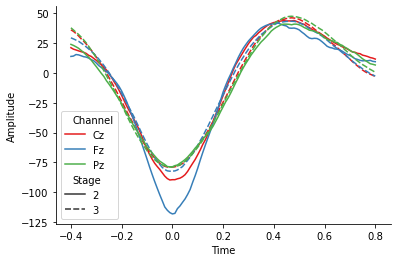

In [7]:
# Then we can use seaborn.lineplot to create the desired plot:
ax = sns.lineplot(data=df_sync, x="Time", y="Amplitude", hue="Channel", 
                  style="Stage", palette="Set1", ci=None, dashes=True)

sns.despine()

*************

## Example 2: Using a Raw object from MNE-Python

This example demonstrates how to manipulate [MNE Raw object](https://mne-tools.github.io/stable/generated/mne.io.Raw.html#mne.io.Raw). The MNE package has several [functions](https://mne-tools.github.io/stable/python_reference.html#module-mne.io) to load the most standard EEG file formats (EDF, BrainVision, EEGLab, FieldTrip...).

For the sake of this example, we'll load a PSG file encoded in the native MNE format (*.fif) using the [mne.io.read_raw_fif](https://martinos.org/mne/stable/generated/mne.io.read_raw_fif.html) function.

In [8]:
# Load the raw object
raw = mne.io.read_raw_fif('sub-02_mne_raw.fif', preload=True, verbose=False)

In [9]:
# Let's have a look at the data
print('Chan =', raw.ch_names)
print('Sampling frequency =', raw.info['sfreq'])
print('Data shape =', raw._data.shape)

Chan = ['F3', 'F4', 'C3', 'C4', 'O1', 'O2', 'EOG1', 'EOG2', 'EMG1']
Sampling frequency = 100.0
Data shape = (9, 294000)


In [10]:
# Keep only the channels of interests
raw_eeg = raw.copy().pick_types(eeg=True).drop_channels(['O1', 'O2'])
print('Chan =', raw_eeg.ch_names)

Chan = ['F3', 'F4', 'C3', 'C4']


In [11]:
# Multi-channel slow-waves detection
# Note that since we're using a MNE Raw object, there is no need
# to manually specify the sampling frequency and channel names.
# We also use a less conservative amplitude threshold
sw = yasa.sw_detect(raw_eeg, amp_ptp=(50, 400))
print(sw.summary().shape[0], 'slow-waves detected.')
sw.summary().round(3)

282 slow-waves detected.


,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Channel,IdxChannel
0,0.40,0.60,0.83,0.98,1.16,0.76,-51.950,24.293,76.243,331.493,1.316,F3,0
1,15.30,15.77,16.01,16.26,16.54,1.24,-81.465,96.554,178.019,741.746,0.806,F3,0
2,38.53,38.78,38.97,39.20,39.44,0.91,-64.282,80.737,145.019,763.255,1.099,F3,0
3,137.70,137.99,138.29,138.49,139.21,1.51,-63.788,24.904,88.691,295.638,0.662,F3,0
4,196.51,196.81,197.04,197.31,197.71,1.20,-46.628,51.581,98.209,426.996,0.833,F3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,2842.07,2842.45,2842.73,2842.94,2843.13,1.06,-65.999,46.460,112.459,401.638,0.943,C4,3
278,2843.13,2843.35,2843.54,2843.78,2844.01,0.88,-53.510,68.652,122.162,642.959,1.136,C4,3
279,2844.75,2845.03,2845.36,2845.89,2846.17,1.42,-124.029,99.849,223.878,678.417,0.704,C4,3
280,2846.17,2846.39,2846.64,2846.80,2847.00,0.83,-77.389,34.250,111.639,446.554,1.205,C4,3


In [12]:
sw.summary(grp_chan=True)

,Count,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
Channel,,,,,,,
C3,48,1.100000,-65.586750,49.535053,115.121803,452.410610,0.950368
C4,54,1.115370,-79.181103,57.808133,136.989236,548.546712,0.956062
F3,100,1.129200,-70.219874,53.856789,124.076663,486.470542,0.936939
F4,80,1.138375,-67.541603,50.583728,118.125331,457.817541,0.940776


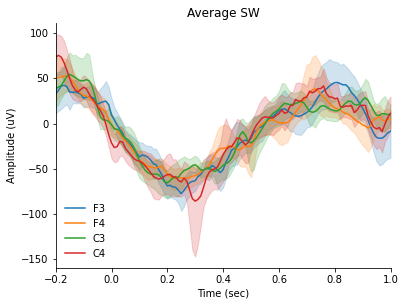

In [13]:
# Plot an average template of the detected slow-waves, centered around the start of the slow-wave
# Definitely noiser than our previous plot since there are fewer detected slow-waves
# in our second datset, because it's a 45 min nap and not a full-night recording!
ax = sw.plot_average(center="Start", time_before=0.2, time_after=1)
ax.legend(frameon=False)
sns.despine()

In [ ]:
# Visual inspection of the detected slow-waves
%matplotlib widget
sw.plot_detection();